# Predicting Fuel Efficiency Using Neural Networks
For something different, I designed a model that that performs regressions
There were alot of models that I experimented with, from LinearRegression, to SVR, to Forest Classifiers, ultimately, Neural networks seem to be the one that works best.
Since this is my first regression model, I'd probably come back here and check to see what I did differently in the future.

### Importing Libraries
One new thing I did here was use SMOTE; the dataset was too small for my neural network to improve upon, so I had to add more datapoints.

In [18]:
import pandas as pd
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import root_mean_squared_error
from imblearn.over_sampling import RandomOverSampler
import numpy as np
import matplotlib as plt

### Importing the dataset


In [21]:
df = pd.read_csv("car_data.csv")

In [23]:
df.head()

,city_mpg,class,combination_mpg,cylinders,displacement,drive,fuel_type,highway_mpg,make,model,transmission,year
0,25,midsize car,29,4.0,2.5,fwd,gas,36,mazda,6,m,2014
1,26,midsize car,30,4.0,2.5,fwd,gas,37,mazda,6,a,2014
2,25,small sport utility vehicle,27,4.0,2.5,fwd,gas,31,mazda,cx-5 2wd,a,2014
3,26,small sport utility vehicle,29,4.0,2.0,fwd,gas,34,mazda,cx-5 2wd,m,2014
4,26,small sport utility vehicle,28,4.0,2.0,fwd,gas,32,mazda,cx-5 2wd,a,2014


### Filing Na values with 0.
When I did check the data there was one vehicle here that is electrice, so understandably, it's displacement and cylinders are NaN. I've opted to remove this from the dataset for now.

In [26]:
df = df.fillna(0)
df.isna().sum()

city_mpg           0
class              0
combination_mpg    0
cylinders          0
displacement       0
drive              0
fuel_type          0
highway_mpg        0
make               0
model              0
transmission       0
year               0
dtype: int64

#### You can see the vehicle here:

(array([352., 187.,   6.,   3.,   0.,   0.,   0.,   0.,   0.,   2.]),
 array([ 11. ,  22.5,  34. ,  45.5,  57. ,  68.5,  80. ,  91.5, 103. ,
        114.5, 126. ]),
 <BarContainer object of 10 artists>)

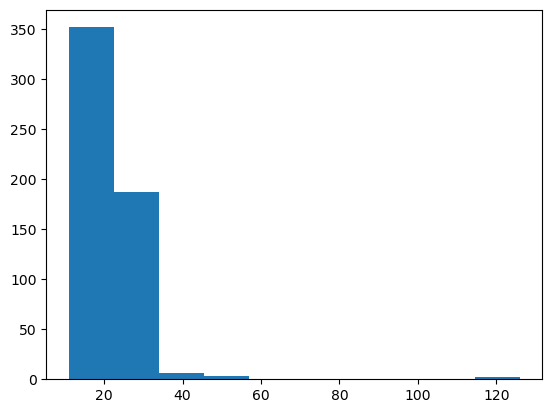

In [29]:
plt.pyplot.hist(df['city_mpg'])

In [31]:
df_clean = df[df['model']!='i-miev']
df_clean

,city_mpg,class,combination_mpg,cylinders,displacement,drive,fuel_type,highway_mpg,make,model,transmission,year
0,25,midsize car,29,4.0,2.5,fwd,gas,36,mazda,6,m,2014
1,26,midsize car,30,4.0,2.5,fwd,gas,37,mazda,6,a,2014
2,25,small sport utility vehicle,27,4.0,2.5,fwd,gas,31,mazda,cx-5 2wd,a,2014
3,26,small sport utility vehicle,29,4.0,2.0,fwd,gas,34,mazda,cx-5 2wd,m,2014
4,26,small sport utility vehicle,28,4.0,2.0,fwd,gas,32,mazda,cx-5 2wd,a,2014
...,...,...,...,...,...,...,...,...,...,...,...,...
545,23,compact car,27,4.0,2.0,awd,gas,33,bmw,430i xdrive gran coupe,a,2024
546,21,midsize car,24,6.0,3.0,rwd,gas,29,bmw,840i gran coupe,a,2024
547,21,midsize car,24,6.0,3.0,awd,gas,29,bmw,840i xdrive gran coupe,a,2024
548,17,midsize car,19,8.0,4.4,awd,gas,24,bmw,m850i xdrive gran coupe,a,2024


#### I've created a function that simply fits and transforms the dataset; since the dataset is a mixture of ordinal and categorical values, I took that conversion into consideration.

In [34]:
enc_ohe = OneHotEncoder(sparse_output=False)
scaler = MinMaxScaler()

def data_transform(train, test, dtype):
    if dtype == "ord":
        X_ord_train = scaler.fit_transform(train)
        X_ord_test = scaler.transform(test)
        return X_ord_train, X_ord_test
    if dtype == "cat":
        X_cat_train = enc_ohe.fit_transform(train)
        X_cat_test =  enc_ohe.transform(test)
        return X_cat_train, X_cat_test

#### For this case, I use Synthetic Oversampling to increase the dataset size; as previous models performed poorly due to low dataset size.
I've also gone ahead and selected only 3 categorical features, mostly as the data's dimensionality would increase considerably if I insisted all features be used. 

In [8]:
sampler = RandomOverSampler()
ordinal = ['city_mpg','cylinders','displacement','highway_mpg']
categorical = ['drive','fuel_type','transmission']

X = df_clean[ordinal + categorical]
y = df_clean['combination_mpg']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42, shuffle=True)
X_train_samp, y_train_samp = sampler.fit_resample(X_train, y_train)

X_ord_train, X_ord_test = data_transform(X_train_samp[ordinal], X_test[ordinal], "ord")
X_cat_train, X_cat_test = data_transform(X_train_samp[categorical], X_test[categorical], "cat")

X_train_complete = np.concatenate((X_ord_train, X_cat_train), axis=1)
X_test_complete = np.concatenate((X_ord_test, X_cat_test), axis=1)

X_train_fin, X_val, y_train_fin, y_val = train_test_split(X_train_complete, y_train_samp, test_size=0.20, shuffle=True)

#### Defining and training the model:

In [9]:
model_neural =  Sequential()
model_neural.add(InputLayer(shape=[X_train_complete.shape[1],]))
model_neural.add(Dense(128, activation='relu'))
model_neural.add(Dense(32, activation='relu'))
model_neural.add(Dense(1, activation=None))
model_neural.compile(optimizer=Adam(learning_rate=0.0001), loss='mae', metrics=['mse', RootMeanSquaredError])

In [12]:
model_neural.fit(X_train_fin, y_train_fin, epochs=750, validation_data=(X_val, y_val))

Epoch 1/750
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 27.1369 - mse: 828.2907 - root_mean_squared_error: 28.7787 - val_loss: 27.9725 - val_mse: 861.8949 - val_root_mean_squared_error: 29.3580
Epoch 2/750
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 26.1880 - mse: 772.1504 - root_mean_squared_error: 27.7811 - val_loss: 27.6967 - val_mse: 846.3969 - val_root_mean_squared_error: 29.0929
Epoch 3/750
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 26.1750 - mse: 775.8618 - root_mean_squared_error: 27.8479 - val_loss: 27.3883 - val_mse: 829.3857 - val_root_mean_squared_error: 28.7991
Epoch 4/750
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 25.9963 - mse: 761.5082 - root_mean_squared_error: 27.5928 - val_loss: 27.0335 - val_mse: 810.2435 - val_root_mean_squared_error: 28.4648
Epoch 5/750
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 24.9451 - mse: 707.7255 - root_mean_squared_error: 26.5892 - val_loss: 26.6246 - val_mse: 788.6661 - val_root_mean_squared_error: 28.0832
Epoch 6/750
25/

#### Unfortunately, this is as low as the model will go.

In [13]:
pred_n = model_neural.predict(X_test_complete)
rmse_n = root_mean_squared_error(y_test, pred_n)
print("\nRMSE: " + str(rmse_n))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

RMSE: 0.35307908058166504
